In [0]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re

import sys
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Embedding, Concatenate, Add, Activation,Dot
from tensorflow.keras.layers import Dense, Input, Flatten,Reshape, MaxPooling2D,MaxPooling3D
from tensorflow.keras.layers import Conv3D, MaxPooling1D, Embedding, Dropout, AdditiveAttention, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import pickle

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
with open('/content/drive/My Drive/narre_data/NARRE_para_filtered_short_review.pkl','rb') as f:
  para = pickle.load(f)

with open('/content/drive/My Drive/narre_data/yelp_NARRE_train_filtered_short_review.pkl','rb') as f:
  train_data = pickle.load(f)

with open('/content/drive/My Drive/narre_data/yelp_NARRE_valid_filtered_short_review.pkl','rb') as f:
  valid_data = pickle.load(f)

In [0]:
## Loading the paramters specific to the data created
## parameters like total number of users, business
## Max sequence length for user and business reviews
## Number of reviews per user and business
## text for user and business
## Word dictionary for user text and business text

total_items = para['item_num']
total_users = para['user_num']
USER_SEQUENCE_LENGTH = para['review_len_u']
ITEM_SEQUENCE_LENGTH = para['review_len_i']
user_review_num = para['review_num_u']
item_review_num = para['review_num_i']
u_text = para['u_text']
i_text = para['i_text']
user_word_index = para['user_vocab']
item_word_index = para['item_vocab']


In [0]:
print(total_items,total_users,USER_SEQUENCE_LENGTH,ITEM_SEQUENCE_LENGTH,user_review_num,item_review_num)#,u_text,i_text,user_word_index,item_word_index)

3940 6113 114 114 85 169


In [0]:
## Rest of parameters for the model
## drop rate of 0.4
## Two filter sizes for text cnn, and each has 100 filters
## Attention dimension kept as 32, same as latent embedding dimension

EMBEDDING_DIM = 100


filter_sizes = [3,4]

conv_filters = 100
drop_rate = 0.2
attention_units = 32
embedding_id = 32



In [0]:
## Loading the glove pre trained embedding and making a matrix named embedding index for it

embeddings_index = {}
f = open('/content/drive/My Drive/yelp_dataset/Dataset/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [0]:
## here we make and fill the embedding matrix for user text, by retreiving vectors from embedding index cretaed before

user_embedding_matrix = np.random.random((len(user_word_index) + 1, EMBEDDING_DIM))
for word, i in user_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        user_embedding_matrix[i] = embedding_vector
user_embedding_layer = Embedding(len(user_word_index) + 1,
                            EMBEDDING_DIM,weights=[user_embedding_matrix],
                            input_length=USER_SEQUENCE_LENGTH,trainable=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
## here we make and fill the embedding matrix for business text, by retreiving vectors from embedding index created before

item_embedding_matrix = np.random.random((len(item_word_index) + 1, EMBEDDING_DIM))
for word, i in item_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        item_embedding_matrix[i] = embedding_vector
item_embedding_layer = Embedding(len(item_word_index) + 1,
                            EMBEDDING_DIM,weights=[item_embedding_matrix],
                            input_length=ITEM_SEQUENCE_LENGTH,trainable=False)

In [0]:
## Passing the user text to embedding and convolution layers

user_sequence_input = Input(shape=(USER_SEQUENCE_LENGTH,user_review_num), dtype='int32')
print(user_sequence_input.shape)
user_embedded_reviews = user_embedding_layer(user_sequence_input)
print(user_embedded_reviews.shape)
user_embedded_reviews_flat = Reshape((user_review_num,USER_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(user_embedded_reviews)
print(user_embedded_reviews_flat.shape)
conv_out = []
for f_size in filter_sizes:
    l_cov1= Conv3D(conv_filters, (1,f_size,EMBEDDING_DIM), activation='relu',padding='valid')(user_embedded_reviews_flat)
    print(l_cov1.shape)
    l_pool1 = MaxPooling3D(pool_size =(1,USER_SEQUENCE_LENGTH-f_size+1,1),padding='valid')(l_cov1)
    print(l_pool1.shape)
    l_flat = Flatten()(l_pool1)
    print(l_flat.shape)
    conv_out.append(l_flat)
conv_joined = Concatenate()(conv_out)
print(conv_joined.shape)    


(?, 114, 85)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 114, 85, 100)
(?, 85, 114, 100, 1)
(?, 85, 112, 1, 100)
(?, 85, 1, 1, 100)
(?, 8500)
(?, 85, 111, 1, 100)
(?, 85, 1, 1, 100)
(?, 8500)
(?, 17000)


In [0]:
## Passing the business text to embedding and convolution layers

item_sequence_input = Input(shape=(ITEM_SEQUENCE_LENGTH,item_review_num), dtype='int32')
item_embedded_reviews = item_embedding_layer(item_sequence_input)
item_embedded_reviews_flat = Reshape((item_review_num,ITEM_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(item_embedded_reviews)
print(item_embedded_reviews_flat.shape)
item_conv_out = []
for f_size in filter_sizes:
    l_cov1= Conv3D(conv_filters, (1,f_size,EMBEDDING_DIM), activation='relu',padding='valid')(item_embedded_reviews_flat)
    print(l_cov1.shape)
    l_pool1 = MaxPooling3D(pool_size =(1,ITEM_SEQUENCE_LENGTH-f_size+1,1),padding='valid')(l_cov1)
    print(l_pool1.shape)
    l_flat = Flatten()(l_pool1)
    print(l_flat.shape)
    item_conv_out.append(l_flat)
item_conv_joined = Concatenate()(item_conv_out)
print(item_conv_joined.shape)    


(?, 169, 114, 100, 1)
(?, 169, 112, 1, 100)
(?, 169, 1, 1, 100)
(?, 16900)
(?, 169, 111, 1, 100)
(?, 169, 1, 1, 100)
(?, 16900)
(?, 33800)


In [0]:
## concatenate convolution fetures for user

user_flat = Reshape((user_review_num,conv_filters*len(filter_sizes)))(conv_joined)
print(user_flat.shape)
user_flat = Dropout(drop_rate)(user_flat)

#total_item = 1000000
u_iid = Input(shape=(user_review_num), dtype='int32')
print(u_iid.shape)
init_a = keras.initializers.RandomUniform(minval=-0.1, maxval=0.1, seed=123)
init_b = tf.keras.initializers.Constant(0.1)

## retreiving the business ids embeddings for a specific user

item_id_embedding = Embedding(total_items + 2,
                            embedding_id,
                            input_length=1,trainable=True,embeddings_initializer=init_a,embeddings_regularizer=l2(0.001))
item_embs = item_id_embedding(u_iid)
item_embs = Activation('relu')(item_embs)
print(item_embs.shape)
##
## Applying user level attention


user_atten = Dense(attention_units,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer=init_a, bias_initializer=init_b)(user_flat)
print(user_atten.shape) 
item_id_atten = Dense(attention_units,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),kernel_initializer=init_a, bias_initializer=init_b)(item_embs)
print(item_id_atten.shape)
added = Add()([user_atten,item_id_atten])
print(added.shape)
added = Activation('relu')(added)
user_a = Dense(1,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),kernel_initializer=init_a, bias_initializer=init_b)(added)
print(user_a.shape)
user_a = tf.keras.activations.softmax(user_a)

## multiply attention weights to learned features from convolution

u_feas = Multiply()([user_flat,user_a])
print(u_feas.shape)

## aggregate features 

u_feas  = tf.keras.backend.sum(u_feas,axis = 1)
print(u_feas.shape)
u_feas = Dropout(drop_rate)(u_feas)

(?, 85, 200)
(?, 85)
(?, 85, 32)
(?, 85, 32)
(?, 85, 32)
(?, 85, 32)
(?, 85, 1)
(?, 85, 200)
(?, 200)


In [0]:
item_flat = Reshape((item_review_num,conv_filters*len(filter_sizes)))(item_conv_joined)
item_flat = Dropout(drop_rate)(item_flat)
## concatenate convolution fetures for business

#total_users = 200000
i_uid = Input(shape=(item_review_num,), dtype='int32')

## retreiving the user ids embeddings for a specific business

user_id_embedding = Embedding(total_users + 2,
                            embedding_id,
                            input_length=1,trainable=True,embeddings_initializer=init_a,embeddings_regularizer=l2(0.001))
user_embs = user_id_embedding(i_uid)
user_embs = Activation('relu')(user_embs)

## Applying business level attention

item_atten = Dense(attention_units,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer=init_a, bias_initializer=init_b)(item_flat)
print(item_atten.shape) 
user_id_atten = Dense(attention_units,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer=init_a, bias_initializer=init_b)(user_embs)
print(user_id_atten.shape)
item_added = Add()([item_atten,user_id_atten])
print(item_added.shape)
item_added = Activation('relu')(item_added)
item_a = Dense(1,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), kernel_initializer=init_a, bias_initializer=init_b)(item_added)
print(item_a.shape)
item_a = tf.keras.activations.softmax(item_a,axis=1)

## multiply attention weights to learned features from convolution

i_feas = Multiply()([item_flat,item_a])
print(i_feas.shape)
i_feas  = tf.keras.backend.sum(i_feas,axis = 1)
print(i_feas.shape)
i_feas = Dropout(drop_rate)(i_feas)


(?, 169, 32)
(?, 169, 32)
(?, 169, 32)
(?, 169, 1)
(?, 169, 200)
(?, 200)


In [0]:
## Prediction Layer
## Retreive the embedding for the specific user and business
## Add this to features learnt for user and business respectively.

## Predict using drop or multiply-relu-dropout-dense-sum combination


uid = Input(shape=(1), dtype='int32')
iid = Input(shape=(1,), dtype='int32')
item_id_embedding = Embedding(total_items + 2,
                            embedding_id,
                            input_length=1,trainable=True,embeddings_initializer=init_a,embeddings_regularizer=l2(0.001))
item_id_emb = item_id_embedding(iid)
print(item_id_emb.shape)

user_id_embedding = Embedding(total_users + 2,
                            embedding_id,
                            input_length=1,trainable=True,embeddings_initializer=init_a,embeddings_regularizer=l2(0.001))
user_id_emb = user_id_embedding(uid)
print(user_id_emb.shape)

u_feas_latent = Dense(embedding_id)(u_feas)
print(user_id_atten.shape)
u_feas = Add()([u_feas_latent,user_id_emb])

i_feas_latent = Dense(embedding_id)(i_feas)
i_feas = Add()([i_feas_latent,item_id_emb])
print(i_feas.shape,u_feas.shape)
u_feas =tf.keras.backend.squeeze(u_feas,axis=1)
i_feas =tf.keras.backend.squeeze(i_feas,axis=1)

#preds = Dot(axes=-1)([u_feas ,i_feas])
#Trial with multiply-drop-dense-add instead of dot

mult_feat = Multiply()([u_feas ,i_feas])
mult_feat = Activation('relu')(mult_feat)
#print("feat shape",mult_feat.shape)
mult_feat_drop = Dropout(drop_rate)(mult_feat)

mult_score = Dense(embedding_id)(mult_feat_drop)
preds = K.sum(mult_score,axis=-1,keepdims=True)

print(preds.shape)

(?, 1, 32)
(?, 1, 32)
(?, 169, 32)
(?, 1, 32) (?, 1, 32)
(?, 1)


In [0]:
## evaluation metric 1 RMSE
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [0]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
## model loss Mean squared error and optimzer Adam with learning rate 0.001

model = Model(inputs=[user_sequence_input,item_sequence_input,u_iid,i_uid,uid,iid], outputs=preds)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              #loss=,
              metrics=[root_mean_squared_error,coeff_determination])

In [0]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 114, 85)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 114, 169)]   0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 114, 85, 100) 12706400    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 114, 169, 100 12880600    input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
train_data = np.array(train_data)

In [0]:
## unzipping train data

duid, diid, dreuid, dreiid, y_batch = zip(*train_data)
duid, diid, dreuid, dreiid = np.array(list(duid)), np.array(list(diid)), np.array(list(dreuid)), np.array(list(dreiid))

In [0]:

y_batch = np.array(y_batch)


In [0]:
## unzipping validation data

vuid, viid, vreuid, vreiid, y_batch_v = zip(*valid_data)
vuid, viid, vreuid, vreiid= np.array(list(vuid)), np.array(list(viid)), np.array(list(vreuid)), np.array(list(vreiid))

In [0]:
y_batch

array([[5.],
       [3.],
       [4.],
       ...,
       [4.],
       [3.],
       [5.]])

In [0]:

y_batch_v = np.array(y_batch_v)


In [0]:
## generator function defined for training and validation

def generator(data, batch_size):
  end_batch_ind = len(data)//batch_size
  #print(end_batch_ind)
  while True:
    for ind in range(0,end_batch_ind):
      #print("ind: ",ind)
      train_batch = data[ind*batch_size:(ind+1)*batch_size]
      duid, diid, dreuid, dreiid, y_batch = zip(*train_batch)
      duid, diid, dreuid, dreiid,y_batch = np.array(list(duid)), np.array(list(diid)), np.array(list(dreuid)), np.array(list(dreiid)),np.array(y_batch)
      u_batch = []
      i_batch = []
      for i in range(len(duid)):
        u_batch.append(u_text[duid[i][0]])
        i_batch.append(i_text[diid[i][0]])
      u_batch = np.array(u_batch)
      i_batch = np.array(i_batch)
      u_batch = np.swapaxes(u_batch,1,2)
      i_batch = np.swapaxes(i_batch,1,2)
      yield [u_batch, i_batch, dreuid, dreiid, duid, diid ],y_batch

#batch_ind = 0
def val_generator(data, batch_size):
  end_batch_ind = len(data)//batch_size
  #print("val, ",end_batch_ind)
  while True:
    for ind in range(0,end_batch_ind):
      #print("val ind: ",ind)
      train_batch = data[ind*batch_size:(ind+1)*batch_size]
      duid, diid, dreuid, dreiid, y_batch = zip(*train_batch)
      duid, diid, dreuid, dreiid,y_batch = np.array(list(duid)), np.array(list(diid)), np.array(list(dreuid)), np.array(list(dreiid)),np.array(y_batch)
      u_batch = []
      i_batch = []
      for i in range(len(duid)):
        u_batch.append(u_text[duid[i][0]])
        i_batch.append(i_text[diid[i][0]])
      u_batch = np.array(u_batch)
      i_batch = np.array(i_batch)
      u_batch = np.swapaxes(u_batch,1,2)
      i_batch = np.swapaxes(i_batch,1,2)
      yield [u_batch, i_batch, dreuid, dreiid, duid, diid ],y_batch


In [0]:
#history = model.fit([u_batch, i_batch, dreuid, dreiid, duid, diid ],y_batch, batch_size=100,epochs = 30, verbose = 1, validation_data = ([u_batch_c, i_batch_c, cvreuid, cvreiid, cvuid, cviid], cy_batch_v),shuffle=True)

batch_size=150
vbatch_size=150
#model.fit_generator(generator(train_data,  batch_size),  steps_per_epoch=len(train_data)//8500,epochs=4,validation_data=generator(valid_data,  vbatch_size),validation_freq=2,validation_steps=len(valid_data)//vbatch_size)
model.fit_generator(generator(train_data,  batch_size),  steps_per_epoch=len(train_data)//batch_size,epochs=26,validation_data=val_generator(valid_data,  vbatch_size),validation_freq=1,validation_steps=len(valid_data)//vbatch_size,shuffle=True)

Epoch 1/26
1587/1587 [==============================] - 1228s 774ms/step - loss: 3.6334 - root_mean_squared_error: 1.3958 - coeff_determination: -1.5392 - val_loss: 1.3289 - val_root_mean_squared_error: 1.1143 - val_coeff_determination: 0.0714
Epoch 2/26
1587/1587 [==============================] - 1214s 765ms/step - loss: 1.3321 - root_mean_squared_error: 1.1211 - coeff_determination: 0.0688 - val_loss: 1.2680 - val_root_mean_squared_error: 1.0973 - val_coeff_determination: 0.0994
Epoch 3/26
1587/1587 [==============================] - 1207s 761ms/step - loss: 1.2791 - root_mean_squared_error: 1.1046 - coeff_determination: 0.0957 - val_loss: 1.2172 - val_root_mean_squared_error: 1.0780 - val_coeff_determination: 0.1312
Epoch 4/26
1587/1587 [==============================] - 1203s 758ms/step - loss: 1.2422 - root_mean_squared_error: 1.0909 - coeff_determination: 0.1176 - val_loss: 1.1862 - val_root_mean_squared_error: 1.0662 - val_coeff_determination: 0.1495
Epoch 5/26
1587/1587 [=====

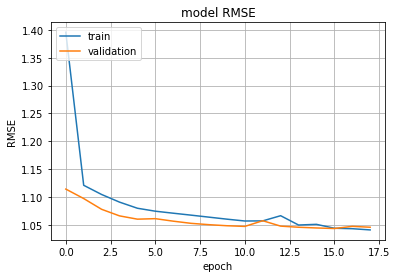

In [0]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# print(history.history.keys())
plt.plot([1.3958,1.1211,1.1046,1.0909,1.0799,1.0746,1.0710,1.0675,1.0639,1.0603,1.0570,1.0572,1.0665,1.0498,1.0510,1.0440,1.0432,1.0410])
plt.plot([1.1143,1.0973,1.0780,1.0662,1.0603,1.0612,1.0567,1.0528,1.0504,1.0485,1.0473,1.0575,1.0478,1.0458,1.0445,1.0435,1.0474,1.0458])  # RAISE ERROR
plt.title('model RMSE')
plt.grid()
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss']) #RAISE ERROR
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [0]:
np.unique(y_batch)

In [0]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(y_batch)
plt.show()

In [0]:
import numpy as np
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(y_batch_v)
plt.show()